<a href="https://colab.research.google.com/github/soltaniehha/Big-Data-Analytics-for-Business/blob/master/model-training/FT-InceptionV3-SubT/FT_TCGA_SubT_IncV3-Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Testing with fully  trained InceptionV3 on TCGA

In [1]:
#  Whether we are in Colab or not?
import sys
is_colab = 'google.colab' in sys.modules

if is_colab:
    from google.colab import auth
    auth.authenticate_user()

In [2]:
####### IMPORT LIBRARY #######

import os
import sys
import time
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

CPU_NUM = psutil.cpu_count(logical=True)
GPU_NUM = len(tf.config.list_physical_devices('GPU'))

In [3]:
def read_tfrecord(example):
    image_feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'rows': tf.io.FixedLenFeature([], tf.int64),
    'cols': tf.io.FixedLenFeature([], tf.int64),
    'channels': tf.io.FixedLenFeature([], tf.int64),   
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    }
    
    # decode the TFRecord
    example = tf.io.parse_single_example(example, image_feature_description)
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(example['label'], tf.int32)
    filename = example['filename']
    
    return image, label, filename

In [4]:
def get_dataset_info(CPU_NUM, filenames):

    label_arr = []
    filename_arr = []
    
    dataset = tf.data.Dataset.list_files(filenames, shuffle=False)
    dataset = dataset.interleave(tf.data.TFRecordDataset, 
                                 cycle_length=CPU_NUM, 
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE,
                                 deterministic=True)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=CPU_NUM)
    
    for image, label, filename in dataset:
        label_arr = np.append(label_arr, label.numpy())
        filename_arr.append(filename.numpy().decode("utf-8"))
    
    return dataset, label_arr, filename_arr

In [5]:
def get_batched_datset(TEST_BATCH_SIZE, dataset):
    dataset = dataset.batch(TEST_BATCH_SIZE, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## Get tfrecords info

In [6]:
###################################################
############ DOWNLOAD THE DATA FROM BQ ############
###################################################

project_id = 'deep-nexus'

# Download query results
tf_info = pd.io.gbq.read_gbq('''
  SELECT * FROM `deep-nexus.tcga_subtype.tfrecords_info`
''', project_id=project_id)

In [7]:
test_info = tf_info[tf_info['tfrecord_paths'].str.contains('test')]
pd.set_option('display.max_colwidth', -1)
test_info.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,tfrecord_paths,n_tiles
6,gs://deep-nexus/TCGA/subtype_tfrecords/test_TCGA-15-0742-01A-01-BS1.tfrecord,1024
7,gs://deep-nexus/TCGA/subtype_tfrecords/test_TCGA-22-4594-01A-01-TS1.tfrecord,1024
8,gs://deep-nexus/TCGA/subtype_tfrecords/test_TCGA-AR-A24Z-01A-01-TSA.tfrecord,1280
16,gs://deep-nexus/TCGA/subtype_tfrecords/test_TCGA-DJ-A2Q6-01A-01-TSA.tfrecord,3328
17,gs://deep-nexus/TCGA/subtype_tfrecords/test_TCGA-50-5932-01A-01-TS1.tfrecord,5632


## Load the model

In [8]:
# Prepare a directory to store the model.
checkpoint_dir = "./ckpt/downloaded-model"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

!gsutil -m -q cp -r gs://deep-nexus/TCGA/models/incV3-FT-SubT ckpt/

model = keras.models.load_model('ckpt/incV3-FT-SubT')

## Make predictions

In [9]:
slide_barcode_arr = []
slide_label_true_arr = []
tile_label_pred_arr = []
tile_name_arr = []

# predict one tfrecord at a time
for i in tqdm(range(test_info.shape[0])):
    
    # get tfrecord info
    tf_path = test_info.tfrecord_paths.values[i]
    tile_num = test_info.n_tiles.values[i]
    tf_name = tf_path.split('/')[-1]
    slide_barcode = tf_name.split('.')[0][5:]
    slide_barcode_arr.append(slide_barcode)
    
    # set params
    TEST_BATCH_SIZE = 128
    
    # get the dataset and the label
    dataset, label_arr, filename_arr = get_dataset_info(CPU_NUM, tf_path)
    slide_label_true_arr.append(int(label_arr[0]))
    tile_name_arr.append([name.split('.')[1].split('/')[-1] for name in filename_arr])
    
    # make tests
    predictions = model.predict(get_batched_datset(TEST_BATCH_SIZE, dataset))
    tile_label_pred = predictions.argmax(axis=1)
    tile_label_pred_arr.append(tile_label_pred)

100%|██████████| 2196/2196 [16:12:07<00:00, 26.56s/it]


## Save the prediction of tiles

In [10]:
slide_label_true_list = []
slide_barcode_list = []

for i in range(len(slide_barcode_arr)):
    sub_list_label = [slide_label_true_arr[i]]*test_info.n_tiles.values[i]
    sub_list_barcode = [slide_barcode_arr[i]]*test_info.n_tiles.values[i]
    slide_label_true_list.append(sub_list_label)
    slide_barcode_list.append(sub_list_barcode)
    
slide_label_true_list = [label for slide in slide_label_true_list for label in slide]
slide_barcode_list = [name for slide in slide_barcode_list for name in slide]
tile_name_list = [name for slide in tile_name_arr for name in slide]
tile_label_pred_list = [pred for slide in tile_label_pred_arr for pred in slide]

In [11]:
test_pred_tile = pd.DataFrame({'slide_barcode': slide_barcode_list,
                                'true_label': slide_label_true_list,
                                'tile_name': tile_name_list,
                                'pred': tile_label_pred_list})
test_pred_tile.head()

,slide_barcode,true_label,tile_name,pred
0,TCGA-15-0742-01A-01-BS1,5,tile_26_12,5
1,TCGA-15-0742-01A-01-BS1,5,tile_5_20,5
2,TCGA-15-0742-01A-01-BS1,5,tile_23_27,5
3,TCGA-15-0742-01A-01-BS1,5,tile_27_13,5
4,TCGA-15-0742-01A-01-BS1,5,tile_32_30,5


In [42]:
disease_code_class = pd.io.gbq.read_gbq('''
  SELECT * FROM `deep-nexus.tcga_subtype.disease_code_class`
''', project_id=project_id)

In [52]:
# Adding the actual labels
test_pred_tile_tmp = test_pred_tile.merge(disease_code_class, how='left', left_on='true_label', right_on='label')
test_pred_tile_tmp = test_pred_tile_tmp[['slide_barcode', 'tile_name', 'disease_code', 'pred']]
test_pred_tile_tmp.columns = ['slide_barcode', 'tile_name', 'true_label', 'pred']
test_pred_tile_tmp = test_pred_tile_tmp.merge(disease_code_class, how='left', left_on='pred', right_on='label')
test_pred_tile_tmp = test_pred_tile_tmp[['slide_barcode', 'tile_name', 'true_label', 'disease_code']]
test_pred_tile_tmp.columns = ['slide_barcode', 'tile_name', 'true_label', 'pred']
test_pred_tile = test_pred_tile_tmp
test_pred_tile

,slide_barcode,tile_name,true_label,pred
0,TCGA-15-0742-01A-01-BS1,tile_26_12,GBM,GBM
1,TCGA-15-0742-01A-01-BS1,tile_5_20,GBM,GBM
2,TCGA-15-0742-01A-01-BS1,tile_23_27,GBM,GBM
3,TCGA-15-0742-01A-01-BS1,tile_27_13,GBM,GBM
4,TCGA-15-0742-01A-01-BS1,tile_32_30,GBM,GBM
...,...,...,...,...
4156017,TCGA-AZ-6600-01A-01-BS1,tile_134_121,COAD,KIRP
4156018,TCGA-AZ-6600-01A-01-BS1,tile_23_75,COAD,COAD
4156019,TCGA-AZ-6600-01A-01-BS1,tile_23_77,COAD,COAD
4156020,TCGA-AZ-6600-01A-01-BS1,tile_47_58,COAD,COAD


In [53]:
tile_acc = accuracy_score(test_pred_tile.true_label, test_pred_tile.pred)
print('Test set tile accuracy: {}'.format(np.round(tile_acc, 4)))

Test set tile accuracy: 0.558


In [54]:
test_pred_tile.to_gbq('tcga_subtype.test_pred_tile_TCGA_SubT_model_on_TCGA', 'deep-nexus', if_exists='replace')

1it [01:42, 102.32s/it]


## Calculate test set slide accuracy

In [107]:
test_slides = test_pred_tile.groupby(['slide_barcode', 'true_label']).agg(
    tile_count     = ('pred', lambda x: x.count()),
    pred_1st       = ('pred', lambda x: x.value_counts().index[0]),
    pred_1st_count = ('pred', lambda x: x.value_counts()[0]),
    pred_1st_ratio = ('pred', lambda x: x.value_counts()[0]/x.count()),
    pred_2nd       = ('pred', lambda x: x.value_counts().index[1] if len(x.value_counts())>1 else None),
    pred_2nd_count = ('pred', lambda x: x.value_counts()[1] if len(x.value_counts())>1 else None),
    pred_2nd_ratio = ('pred', lambda x: x.value_counts()[1]/x.count() if len(x.value_counts())>1 else None),
    pred_3rd       = ('pred', lambda x: x.value_counts().index[2] if len(x.value_counts())>2 else None),
    pred_3rd_count = ('pred', lambda x: x.value_counts()[2] if len(x.value_counts())>2 else None),
    pred_3rd_ratio = ('pred', lambda x: x.value_counts()[2]/x.count() if len(x.value_counts())>2 else None)

).reset_index()

test_slides

,slide_barcode,true_label,tile_count,pred_1st,pred_1st_count,pred_1st_ratio,pred_2nd,pred_2nd_count,pred_2nd_ratio,pred_3rd,pred_3rd_count,pred_3rd_ratio
0,TCGA-02-0001-01C-01-BS1,GBM,1556,GBM,1554,0.998715,OV,2.0,0.001285,None,NaN,NaN
1,TCGA-02-0010-01A-01-BS1,GBM,997,GBM,997,1.000000,None,NaN,NaN,None,NaN,NaN
2,TCGA-02-0010-01A-01-TS2,GBM,1292,GBM,1291,0.999226,LUSC,1.0,0.000774,None,NaN,NaN
3,TCGA-02-0021-01A-01-BS1,GBM,1364,GBM,1362,0.998534,LGG,1.0,0.000733,OV,1.0,0.000733
4,TCGA-02-0021-01A-01-TS1,GBM,2475,GBM,2269,0.916768,OV,79.0,0.031919,KIRC,70.0,0.028283
...,...,...,...,...,...,...,...,...,...,...,...,...
2191,TCGA-ZJ-AAXN-01A-01-TSA,CESC,2070,BLCA,1117,0.539614,LIHC,667.0,0.322222,LGG,97.0,0.046860
2192,TCGA-ZM-AA0D-01A-01-TSA,TGCT,1157,BLCA,492,0.425238,PRAD,281.0,0.242869,KIRP,162.0,0.140017
2193,TCGA-ZM-AA0N-01A-02-TS2,TGCT,3985,PRAD,1629,0.408783,BLCA,1112.0,0.279046,UCEC,659.0,0.165370
2194,TCGA-ZP-A9CV-01A-01-TS1,LIHC,1284,LIHC,1265,0.985202,KIRP,13.0,0.010125,BLCA,5.0,0.003894


In [115]:
slide_acc_top1 = sum(test_slides.true_label == test_slides.pred_1st)/test_slides.shape[0]
slide_acc_top2 = (sum(test_slides.true_label == test_slides.pred_1st) +
                  sum(test_slides.true_label == test_slides.pred_2nd))/test_slides.shape[0]
slide_acc_top3 = (sum(test_slides.true_label == test_slides.pred_1st) +
                  sum(test_slides.true_label == test_slides.pred_2nd) +
                  sum(test_slides.true_label == test_slides.pred_3rd))/test_slides.shape[0]
print('Test set slide top 1 accuracy: {}'.format(np.round(slide_acc_top1, 4)))
print('Test set slide top 2 accuracy: {}'.format(np.round(slide_acc_top2, 4)))
print('Test set slide top 3 accuracy: {}'.format(np.round(slide_acc_top3, 4)))

Test set slide top 1 accuracy: 0.6539
Test set slide top 2 accuracy: 0.7281
Test set slide top 3 accuracy: 0.7568


In [116]:
test_slides.to_gbq('tcga_subtype.test_pred_slide_TCGA_SubT', 'deep-nexus', if_exists='replace')

1it [00:03,  3.68s/it]


In [16]:
# Viz

In [3]:
project_id  = 'deep-nexus'
test_slides = pd.io.gbq.read_gbq('''
  SELECT * FROM `deep-nexus.tcga_subtype.test_pred_slide_TCGA_SubT`
''', project_id=project_id)

In [4]:
test_slides['Prediction'] = test_slides['true_label'] == test_slides['pred_1st']

In [5]:
test_slides.head(1)

,slide_barcode,true_label,tile_count,pred_1st,pred_1st_count,pred_1st_ratio,pred_2nd,pred_2nd_count,pred_2nd_ratio,pred_3rd,pred_3rd_count,pred_3rd_ratio,Prediction
0,TCGA-02-0010-01A-01-BS1,GBM,997,GBM,997,1.0,None,NaN,NaN,None,NaN,NaN,True


In [6]:
test_slides.sort_values(by='true_label', inplace=True)

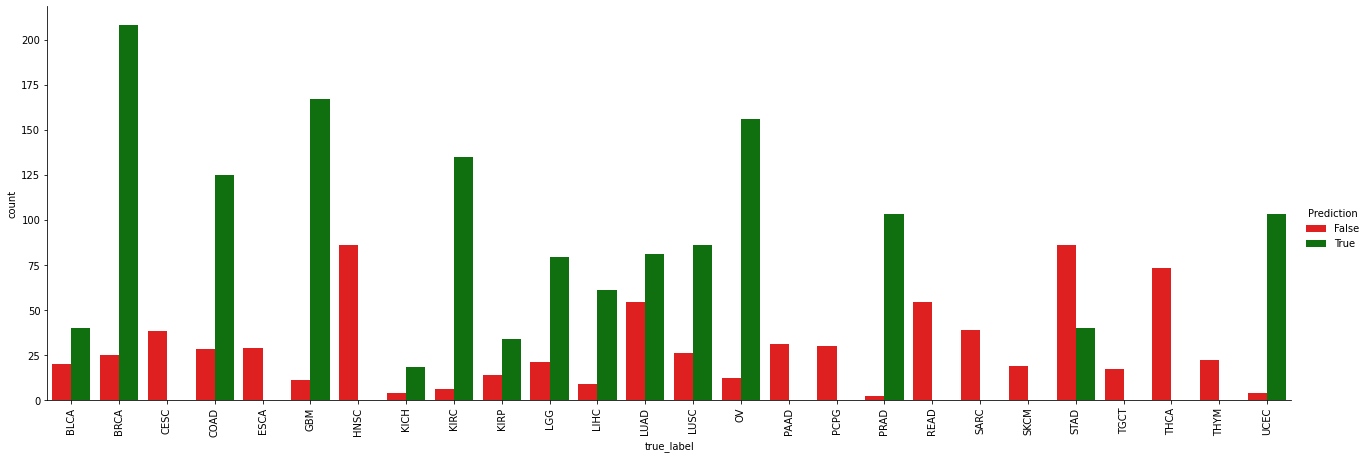

In [7]:
g = sns.catplot(data=test_slides, x='true_label', hue='Prediction', kind='count',
                height=6, aspect=3, palette=sns.color_palette(['red', 'green']))
g.set_xticklabels(rotation=90);

In [13]:
subT_acc  = test_slides[['true_label','pred_1st']].groupby('true_label').agg(lambda x: accuracy_score(x.true_label, x.pred_1st)).reset_index()

In [14]:
subT_acc.columns = ['subType',  'top_1_accuracy']

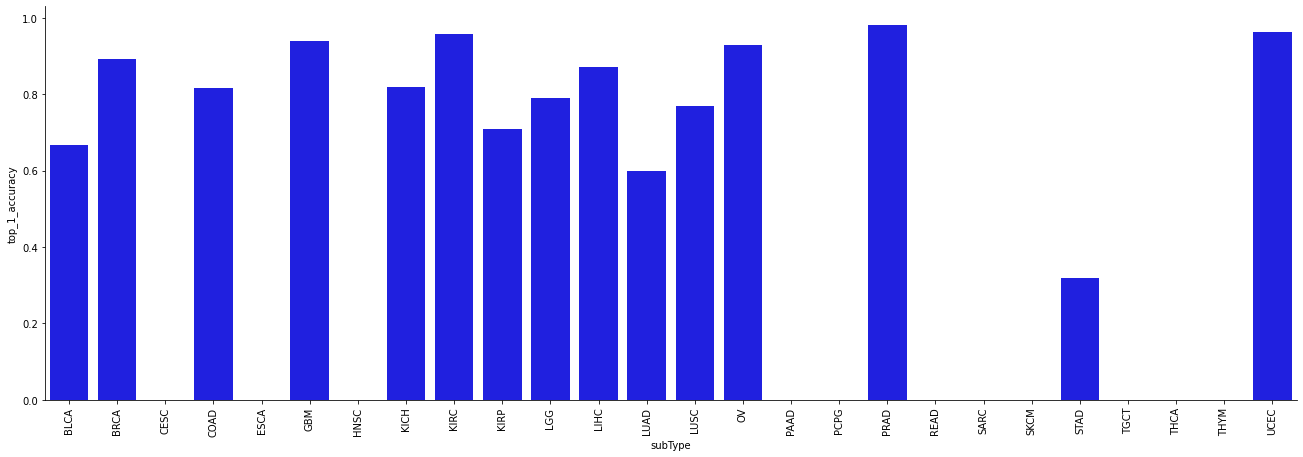

In [16]:
g = sns.catplot(data=subT_acc, x='subType', y='top_1_accuracy', kind='bar',
                height=6, aspect=3, color='b')
g.set_xticklabels(rotation=90);